In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc import fft
from pycbc.filter import match, overlap_cplx, sigma, sigmasq, make_frequency_series
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.waveform import taper_timeseries
from pycbc.types import timeseries, frequencyseries, zeros, complex_same_precision_as
from calcwf import gen_wf, get_h, overlap_cplx_wfs, match_wfs, shifted_f, shifted_e, chirp2total, trim_wf, ceiltwo, taper_wf

# Normalisation with 3 waveform components

As before will start with the following, now using the notation of labelling $h_0, \ldots, h_{n-1}$:

$$
h = Ah_0+Bh_1+Ch_2
$$
$$
h_0 = \frac{1}{3}\left(s_0+s_1+s_2\right)
$$
$$
h_1 = \frac{1}{3}\left(s_0+\omega s_1+\omega^2 s_2\right)
$$
$$
h_2 = \frac{1}{3}\left(s_0+\omega^2s_1+\omega s_2\right)
$$

where $\omega$ is the first primitive $n=3$ root of unity.

Here and throughout we will make extensive use of the following properties:

$$
(\lambda_1 \alpha_1 | \lambda_2 \alpha_2) = \lambda_1 \lambda_2^* (\alpha_1| \alpha_2)
$$

$$
(\omega^a)^* = \omega^{-a} = \omega^{n-a}
$$

We now want to enforce the condition

$$
\frac{(h|h_0)}{(h_0|h_0)} = A\frac{(h_0|h_0)}{(h_0|h_0)} + B\frac{(h_1|h_0)}{(h_0|h_0)} + C\frac{(h_2|h_0)}{(h_0|h_0)} = A
$$

which requires $(h_j|h_m) = 0$ for $j\neq m$.

From $n=2$ case we can normalise such that $(s_j|s_j)$ are equal for all $j$. We also expect $(s_0|s_1) = (s_1|s_2)  = (s_2|s_0)$ as they all differ by the same true anomaly (and similarly $(s_1|s_0) = (s_2|s_1) = (s_0|s_2)$).

For e.g. $(h_1|h_2)$, this comes down to enforcing

$$
(h_1|h_2) \propto (s_0|s_0) + \omega(s_0|s_1) + \omega^2(s_0|s_2) + \omega(s_1|s_0) + \omega^2(s_1|s_1) + (s_1|s_2) + \omega^2(s_2|s_0) + (s_2|s_1) + \omega(s_2|s_2) = 0
$$

$$
(1+\omega^2+\omega)(s_0|s_0) + (\omega+1+\omega^2)(s_0|s_1) + (\omega+1+\omega^2)(s_1|s_0) = 0
$$

$$
0 = 0
$$

We therefore see that simply normalising in the same way as the $n=2$ case also enforces $(h_1|h_2)$ to be zero in the $n=3$ case.

Repeat for $(h_0|h_1)$ and $(h_2|h_0)$ now to check these also equal zero:

$$
(h_0|h_1) \propto (s_0|s_0) + \omega^2(s_0|s_1) + \omega(s_0|s_2) + (s_1|s_0) + \omega^2(s_1|s_1) + \omega(s_1|s_2) + (s_2|s_0) + \omega^2(s_2|s_1) + \omega(s_2|s_2)
$$

$$
(h_0|h_1) \propto (1+\omega^2+\omega)(s_0|s_0) + (\omega^2+\omega+1)(s_0|s_1) + (1+\omega^2+\omega)(s_1|s_0)
$$

$$
(h_0|h_1) \propto 0
$$

and

$$
(h_2|h_0) \propto (s_0|s_0) + (s_0|s_1) + (s_0|s_2) + \omega^2(s_1|s_0) + \omega^2(s_1|s_1) + \omega^2(s_1|s_2) + \omega(s_2|s_0) + \omega(s_2|s_1) + \omega(s_2|s_2)
$$

$$
(h_2|h_0) \propto (1+\omega^2+\omega)(s_0|s_0) + (1+\omega^2+\omega)(s_0|s_1) + (\omega^2+\omega+1)(s_1|s_0)
$$

$$
(h_2|h_0) \propto 0
$$

We therefore find that the simple normalisation we used for $n=2$ also works in the $n=3$ case, allowing us to write:

$$
\frac{(h|h_0)}{(h_0|h_0)} = A\frac{(h_0|h_0)}{(h_0|h_0)} + B\frac{(h_1|h_0)}{(h_0|h_0)} + C\frac{(h_2|h_0)}{(h_0|h_0)} = A
$$
$$
\frac{(h|h_1)}{(h_1|h_1)} = A\frac{(h_0|h_1)}{(h_1|h_1)} + B\frac{(h_1|h_1)}{(h_1|h_1)} + C\frac{(h_2|h_1)}{(h_1|h_1)} = B
$$
$$
\frac{(h|h_2)}{(h_2|h_2)} = A\frac{(h_0|h_2)}{(h_2|h_2)} + B\frac{(h_1|h_2)}{(h_2|h_2)} + C\frac{(h_2|h_2)}{(h_2|h_2)} = C
$$

For completeness, let's also calculate all (h_j|h_j):

$$
(h_0|h_0) \propto (s_0|s_0) + (s_0|s_1) + (s_0|s_2) + (s_1|s_0) + (s_1|s_1) + (s_1|s_2) + (s_2|s_0) + (s_2|s_1) + (s_2|s_2)
$$

$$
(h_0|h_0) \propto 3(s_0|s_0) + 3(s_0|s_1) + 3(s_1|s_0)
$$

$$
(h_0|h_0) = \frac{1}{3}(s_0|s_0) + \frac{1}{3}(s_0|s_1) + \frac{1}{3}(s_1|s_0)
$$

$$
(h_1|h_1) \propto (s_0|s_0) + \omega^2(s_0|s_1) + \omega(s_0|s_2) + \omega(s_1|s_0) + (s_1|s_1) + \omega^2(s_1|s_2) + \omega^2(s_2|s_0) + \omega(s_2|s_1) + (s_2|s_2)
$$

$$
(h_1|h_1) \propto 3(s_0|s_0) + 3\omega^2(s_0|s_1) + 3\omega(s_1|s_0)
$$

$$
(h_1|h_1) = \frac{1}{3}(s_0|s_0) + \frac{\omega^2}{3}(s_0|s_1) + \frac{\omega}{3}(s_1|s_0)
$$

$$
(h_2|h_2) \propto (s_0|s_0) + \omega(s_0|s_1) + \omega^2(s_0|s_2) + \omega^2(s_1|s_0) + 1(s_1|s_1) + \omega(s_1|s_2) + \omega(s_2|s_0) + \omega^2(s_2|s_1) + 1(s_2|s_2)
$$

$$
(h_2|h_2) \propto 3(s_0|s_0) + 3\omega(s_0|s_1) + 3\omega^2(s_1|s_0)
$$

$$
(h_2|h_2) = \frac{1}{3}(s_0|s_0) + \frac{\omega}{3}(s_0|s_1) + \frac{\omega^2}{3}(s_1|s_0)
$$

# Normalisation with n waveform components

Now let's attempt to do this for $n$ waveform components. Note the subscript $j$ here refers to the order of the nth roots of unity eigenvectors, not the $h_1,\ldots,h_n$ in order of dominance. This order differs for $n>3$. (see Eigenvector Order Prediction in principal_component_analysis.ipynb for more details).

$$
h = \sum_{j=0}^{n-1} A_j h_j
$$
$$
h_j = \frac{1}{n}\sum_{k=0}^{n-1} \omega_n^{jk} s_k
$$

where $\omega_n$ is the first primitive $n$th root of unity, defined as equal to $e^{(2 \pi i/n)}$.

Now calculate $(h_j|h_m)$.

$$
(h_j|h_m) \propto \sum_{k=0}^{n-1} \sum_{l=0}^{n-1} \omega_n^{(jk-ml)} (s_k|s_l)
$$

Separate out diagonal terms:

$$
(h_j|h_m) \propto \sum_{k=0}^{n-1} \omega_n^{k(j-m)} (s_k|s_k) + \sum_{k,l=0 \atop k\neq l}^{n-1} \omega_n^{(jk-ml)} (s_k|s_l)
$$

And only sum over unique pairs:

$$
(h_j|h_m) \propto \sum_{k=0}^{n-1} \omega_n^{k(j-m)} (s_k|s_k) + \sum_{k=0}^{n-1}\sum_{l=k+1}^{n-1} \omega_n^{(jk-ml)} (s_k|s_l) + \sum_{k=0}^{n-1}\sum_{l=k+1}^{n-1}\omega_n^{(jl-mk)} (s_l|s_k)
$$

Can see immediately that the roots of unity in the first term will either all be 1 if $j=m$, or sum to zero otherwise, as $\sum_{k=0}^{n-1}\left(\omega_n^b\right)^k = 0$ for $b~\mathrm{mod}~n \neq 0$. The first term therefore disappears for $j\neq m$.

We can also now collect 'like-terms' in the off-diagonal sums by using e.g. $(s_0|s_1) = (s_1|s_2) = (s_2|s_3) = (s_3|s_0)$ and $(s_0|s_2) = (s_1|s_3)$ in the $n=4$ case.

$$
(h_j|h_m) \propto \sum_{k=0}^{n-1} \omega_n^{k(j-m)} (s_k|s_k) + \sum_{r=1}^{\lfloor n/2\rfloor} \sum_{t=0}^{p-1} \omega_n^{(jt-m(t+r))} (s_0|s_r) + \sum_{r=1}^{\lfloor n/2\rfloor} \sum_{t=0}^{p-1} \omega_n^{(j(t+r)-mt)} (s_r|s_0)
$$

where $\lfloor x \rfloor$ denotes the floor of $x$, and p is the number of pairs that can be made from the index difference $r$, equal to:

$$ p=   \left\{
\begin{array}{ll}
      0 & r>n/2 \\
      n/2 & r=n/2 \\
      n & r<n/2 \\
\end{array} 
\right.  $$

Simplifying slightly further,

$$
(h_j|h_m) \propto \sum_{k=0}^{n-1} \omega_n^{k(j-m)} (s_k|s_k) + \sum_{r=1}^{\lfloor n/2\rfloor} \omega_n^{-mr} \sum_{t=0}^{p-1} \omega_n^{t(j-m)} (s_0|s_r) + \sum_{r=1}^{\lfloor n/2\rfloor} \omega_n^{jr} \sum_{t=0}^{p-1} \omega_n^{t(j-m)} (s_r|s_0)
$$

We now see once again that for $j=m$, the coefficients $\omega_n^{t(j-m)}$ are simply all 1. We can now read off that for general $n$, $(h_j|h_j)$ is equal to:

$$
(h_j|h_j) = \frac{1}{n} (s_k|s_k) + \sum_{r=1}^{\lfloor n/2\rfloor} \frac{p}{n^2} \omega_n^{-jr} (s_0|s_r) + \sum_{r=1}^{\lfloor n/2\rfloor} \frac{p}{n^2} \omega_n^{jr} (s_r|s_0)
$$

which is consistent with the $n=3$ case we have calculated explicitly.

Returning to the $j\neq m$ case, for each $r$ being summed over, we can either have $p=n$, or $p=n/2$. In the former case, it is obvious that the off-diagonal terms reduce to zero in the same way as for the diagonal term, using $\sum_{t=0}^{n-1}\left(\omega_n^b\right)^t = 0$.

For the $p=n/2$ case, we recognise that $n$ must be even as $r=n/2$. We also have for this case $(s_0|s_{n/2}) = (s_{n/2}|s_0)$, allowing us to combine both off-diagonal terms as below:

$$
\left(\omega_n^{-mn/2}+\omega_n^{jn/2}\right) \sum_{t=0}^{n/2-1} \omega_n^{t(j-m)} (s_0|s_{n/2})
$$

If $j$ is even, and $m$ odd (or vice versa), then $\omega_n^{-mn/2} = -\omega_n^{jn/2}$, and this term is also reduced to zero. In the last remaining case, where the combination of $(j-m)$ is even, we can use the fact that $\omega_{2n}^{2c} = \omega_{n}^c$ for integer $c$.

$$
\left(\omega_n^{-mn/2}+\omega_n^{jn/2}\right) \sum_{t=0}^{n/2-1} \omega_{n/2}^{t(j-m)/2} (s_0|s_{n/2})
$$

Finally we see that this term is also zero now, using once again the same identity as before: $\sum_{t=0}^{n/2-1}\left(\omega_{n/2}^b\right)^t = 0$.

In summary, we have shown that with our normalisation, $(h_j|h_m) = 0$ for $j\neq m$, and calculated the form for $j=m$.

We can now simply write the following for all coefficients $A_j$:

$$
\frac{(h|h_m)}{(h_m|h_m)} = \sum_{j}^{n-1} A_j\frac{(h_j|h_m)}{(h_m|h_m)} = A_m
$$

In reality we will not normalise $(s_j|s_j)$ to 1, as we would like to retain units/scale. Instead we will normalise to $(s_0|s_0)$ as follows:

$$
\hat{s}_j = s_j \frac{\sqrt{(s_0|s_0)}}{\sqrt{(s_j|s_j)}}
$$

such that

$$
(\hat{s}_j|\hat{s}_j) = (s_j|s_j) \frac{(s_0|s_0)}{(s_j|s_j)} = (s_0|s_0)
$$

for all $j$.

# Building three component waveforms

Let's build our three component waveform model here to use for testing purposes.

In [2]:
def taper_wf(wf_taper):
    """
    Tapers start of input waveform using pycbc.waveform taper_timeseries() function.

    Parameters:
        wf_taper: Waveform to be tapered.
        
    Returns:
        Tapered waveform.
    """
    
    wf_taper_p = taper_timeseries(wf_taper.real(), tapermethod='start')
    wf_taper_c = taper_timeseries(-wf_taper.imag(), tapermethod='start')
    wf_taper = wf_taper_p - 1j*wf_taper_c

    return wf_taper
    
def gen_component_wfs(f_low, e, M, q, n, sample_rate, approximant, normalisation, taper):
    '''
    Creates n component waveforms used to make h_1,...,h_n, all equally spaced in
    true anomaly.
    
    Parameters:
        f_low: Starting frequency.
        e: Eccentricity.
        M: Total mass.
        q: Mass ratio.
        sample_rate: Sample rate of waveform.
        approximant: Approximant to use.
        normalisation: Whether to normalise h_ap and h_peri components to ensure (h1|h2) = 0.
        taper: Whether to taper start of waveform.
        
    Returns:
        Component waveforms.
    '''

    # Generate shifted frequency, eccentricity, phase values
    max_s_f = shifted_f(f_low, e, M, q)
    s_f_vals = np.linspace(f_low, max_s_f, n, endpoint=False)
    s_e_vals = shifted_e(s_f_vals, f_low, e)

    comp_wfs = []
    # Generate all component waveforms
    for i, (s_f, s_e) in enumerate(zip(s_f_vals, s_e_vals)):

        # Create waveform
        h = gen_wf(s_f, s_e, M, q, sample_rate, approximant, phase=0)
        
        if i > 0:

            # Trim waveform to same size as first (shortest), and corrects phase
            h = trim_wf(h, comp_wfs[0])
            overlap = overlap_cplx_wfs(h, comp_wfs[0], f_low)
            phase_angle = np.angle(overlap)/2
            h = gen_wf(s_f, s_e, M, q, sample_rate, approximant, phase=phase_angle)
            h = trim_wf(h, comp_wfs[0])

            # Tapers if requested
            if taper:
                h = taper_wf(h)
            
            # Normalises waveform if requested
            if normalisation:
                sigma_h = sigma(h.real(), psd=psd, low_frequency_cutoff=f_low+3)
                h *= sigma_0/sigma_h
                
        # Work out normalisation of first waveform        
        elif normalisation:

            # Tapers if requested
            if taper:
                h = taper_wf(h)
            
            # Generate the aLIGO ZDHP PSD
            h.resize(ceiltwo(len(h))) 
            delta_f = 1.0 / h.duration
            flen = len(h)//2 + 1
            psd = aLIGOZeroDetHighPower(flen, delta_f, f_low+3)
        
            # Calculates normalisation factor using sigma function
            sigma_0 = sigma(h.real(), psd=psd, low_frequency_cutoff=f_low+3)

        comp_wfs.append(h)

    return comp_wfs

In [3]:
s_0, s_1, s_2 = gen_component_wfs(10, 0.1, chirp2total(24,2), 2, 3, 4096, 'TEOBResumS', True, False)

/home/ben.patterson/.conda/envs/teobresums_eccentric/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-7.0, -5.0)

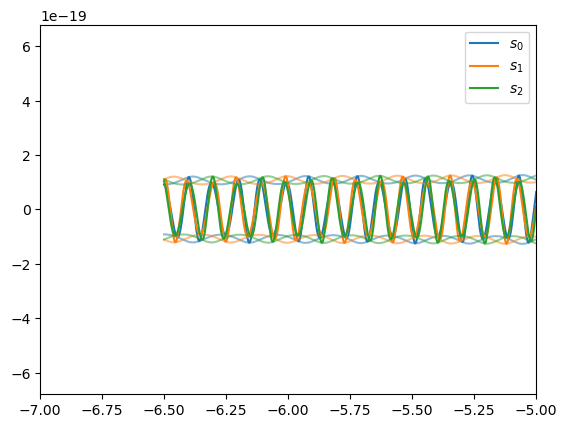

In [4]:
# Plot waveforms with envelopes
plt.plot(s_0.sample_times, s_0, c='C0', label='$s_0$')
plt.plot(s_0.sample_times, np.sqrt(s_0.real()**2 + s_0.imag()**2), c='C0', alpha=0.5)
plt.plot(s_0.sample_times, -np.sqrt(s_0.real()**2 + s_0.imag()**2), c='C0', alpha=0.5)
plt.plot(s_1.sample_times, s_1, c='C1', label='$s_1$')
plt.plot(s_1.sample_times, np.sqrt(s_1.real()**2 + s_1.imag()**2), c='C1', alpha=0.5)
plt.plot(s_1.sample_times, -np.sqrt(s_1.real()**2 + s_1.imag()**2), c='C1', alpha=0.5)
plt.plot(s_2.sample_times, s_2, c='C2', label='$s_2$')
plt.plot(s_2.sample_times, np.sqrt(s_2.real()**2 + s_2.imag()**2), c='C2', alpha=0.5)
plt.plot(s_2.sample_times, -np.sqrt(s_2.real()**2 + s_2.imag()**2), c='C2', alpha=0.5)
plt.legend()
plt.xlim(-7,-5)

Now check that normalisation has worked i.e. $(s_j|s_j)$ is equal for all $j$.

In [5]:
a=  [1.05245,2.2432414,3.23462,4.235453,5.25532]
a_ts = timeseries.TimeSeries(a, 1/4096, epoch=0, dtype='complex64')
b_ts = a_ts - 1j*a_ts
N = len(b_ts)
delta_f = 1.0 / N / b_ts.delta_t
vectilde =  frequencyseries.FrequencySeries(np.zeros(N, dtype='complex64'),
                            delta_f=delta_f, copy=False)
b_fs = fft.fft(b_ts, vectilde)

In [8]:
# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / s_0.duration
flen = len(s_0)
psd = aLIGOZeroDetHighPower(flen, delta_f, 10+3)

# Calculates (s_j|s_j) for j=0,1,2
s_0_sigma = sigmasq(s_0, psd=psd, low_frequency_cutoff=10+3)
s_1_sigma = sigmasq(s_1, psd=psd, low_frequency_cutoff=10+3)
s_2_sigma = sigmasq(s_2, psd=psd, low_frequency_cutoff=10+3)

print(s_0_sigma, s_1_sigma, s_2_sigma)

1825871628.4136622 1826058422.8809745 1820111969.7511933


Now check whether $(s_0|s_1)=(s_2|s_0)=(s_1|s_2)$.

In [10]:
# Calculate (s_0|s_1), etc.
s0_s1 = abs(overlap_cplx(s_0, s_1, psd=psd, low_frequency_cutoff=10+3))
s2_s0 = abs(overlap_cplx(s_2, s_0, psd=psd, low_frequency_cutoff=10+3))
s1_s2 = abs(overlap_cplx(s_1, s_2, psd=psd, low_frequency_cutoff=10+3))

print(s0_s1, s2_s0, s1_s2)

0.9524703024499097 0.9519919778358115 0.9506634675289575


These are very close, although not exactly the same.

Let's build h0, h1, h2 for testing

In [11]:
# Find primitive root of unity
roots_unity = np.roots([1,0,0,-1])
prim_root_arg = np.argmin(np.angle(roots_unity)[np.angle(roots_unity)>0])
prim_root = roots_unity[np.angle(roots_unity)>0][prim_root_arg]

# Build h0, h1, h2
hs = []
for i in range(3):
    hs.append((1/3)*(s_0 + prim_root**i * s_1 + prim_root**(2*i) * s_2))
h_0, h_1, h_2 = hs

In [12]:
# Get h0, h1 with n=2 for comparison
_, h_0_n2, h_1_n2, _, _ = get_h([1,1], 10, 0.1, chirp2total(24, 2), 2, 4096, approximant='TEOBResumS')

(-6.0, -5.0)

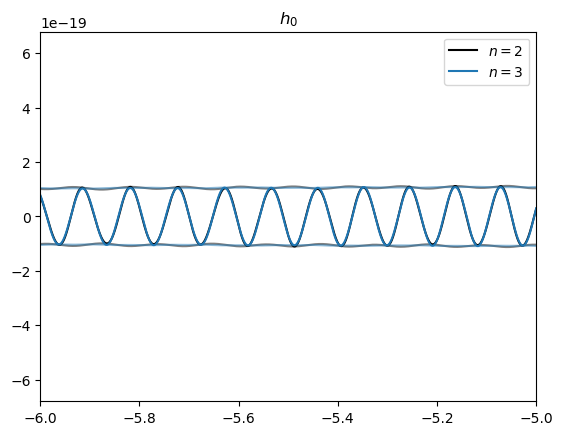

In [13]:
# Plot first waveform
plt.plot(h_0_n2.sample_times, h_0_n2, c='k', label='$n=2$')
plt.plot(h_0_n2.sample_times, np.sqrt(h_0_n2.real()**2 + h_0_n2.imag()**2), c='k', alpha=0.5)
plt.plot(h_0_n2.sample_times, -np.sqrt(h_0_n2.real()**2 + h_0_n2.imag()**2), c='k', alpha=0.5)
plt.plot(h_0.sample_times, h_0, c='C0', label='$n=3$')
plt.plot(h_0.sample_times, np.sqrt(h_0.real()**2 + h_0.imag()**2), c='C0', alpha=0.5)
plt.plot(h_0.sample_times, -np.sqrt(h_0.real()**2 + h_0.imag()**2), c='C0', alpha=0.5)
plt.title('$h_0$')
plt.legend()
plt.xlim(-6,-5)

(-6.0, -5.0)

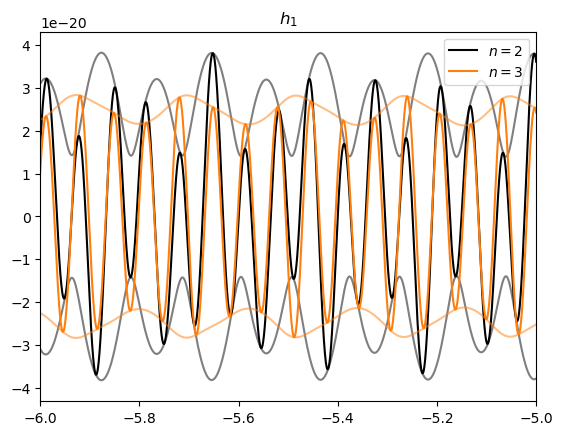

In [14]:
# Plot second waveform
plt.plot(h_1_n2.sample_times, h_1_n2, c='k', label='$n=2$')
plt.plot(h_1_n2.sample_times, np.sqrt(h_1_n2.real()**2 + h_1_n2.imag()**2), c='k', alpha=0.5)
plt.plot(h_1_n2.sample_times, -np.sqrt(h_1_n2.real()**2 + h_1_n2.imag()**2), c='k', alpha=0.5)
plt.plot(h_1.sample_times, h_1, c='C1', label='$n=3$')
plt.plot(h_1.sample_times, np.sqrt(h_1.real()**2 + h_1.imag()**2), c='C1', alpha=0.5)
plt.plot(h_1.sample_times, -np.sqrt(h_1.real()**2 + h_1.imag()**2), c='C1', alpha=0.5)
plt.title('$h_1$')
plt.legend()
plt.xlim(-6,-5)

(-6.0, -5.0)

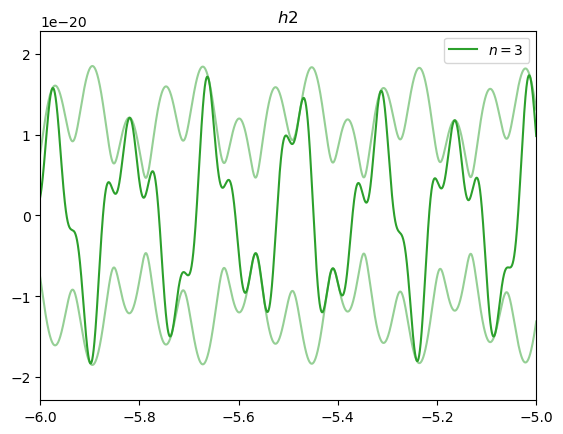

In [15]:
# Plot third waveform
plt.plot(h_2.sample_times, h_2, c='C2', label='$n=3$')
plt.plot(h_2.sample_times, np.sqrt(h_2.real()**2 + h_2.imag()**2), c='C2', alpha=0.5)
plt.plot(h_2.sample_times, -np.sqrt(h_2.real()**2 + h_2.imag()**2), c='C2', alpha=0.5)
plt.title('$h2$')
plt.legend()
plt.xlim(-6,-5)

In [18]:
# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / h_0.duration
flen = len(h_0)
psd = aLIGOZeroDetHighPower(flen, delta_f, 10+3)

# Calculates (h_j|h_j) for j=0,1,2
h_0_sigma = sigmasq(h_0, psd=psd, low_frequency_cutoff=10+3)
h_1_sigma = sigmasq(h_1, psd=psd, low_frequency_cutoff=10+3)
h_2_sigma = sigmasq(h_2, psd=psd, low_frequency_cutoff=10+3)

print(h_0_sigma, h_1_sigma, h_2_sigma)

# Calculate (h_0|h_1), etc.
h0_h1 = abs(overlap_cplx(h_0, h_1, psd=psd, low_frequency_cutoff=10+3))
h2_h0 = abs(overlap_cplx(h_2, h_0, psd=psd, low_frequency_cutoff=10+3))
h1_h2 = abs(overlap_cplx(h_1, h_2, psd=psd, low_frequency_cutoff=10+3))

print(h0_h1, h2_h0, h1_h2)

1763655265.695634 48011974.087018244 12346767.232624486
0.1214336562098542 0.24171117666631556 0.04894408458298955


# Testing generalised get_h()

First test just with $n=2$ to make sure it still works

In [ ]:
h, h1, h2, h_ap, h_peri = get_h([1,1], 10, 0.1, chirp2total(24, 2), 2, 4096, approximant='TEOBResumS')

In [ ]:
plt.plot(h.sample_times, h)

In [ ]:
plt.plot(h.sample_times, h1)
plt.plot(h.sample_times, h2)

In [ ]:
plt.plot(h.sample_times, h_ap)
plt.plot(h.sample_times, h_peri)
plt.xlim(-6,-4)

All plots look sensible! Nothing is clearly broken.

Now move on to $n=3$ case. Note that the number of TEOB calls required is equal to $2n-1$.

In [ ]:
h, h1, h2, h3, s1, s2, s3 = get_h([1,1,1], 10, 0.1, chirp2total(24, 2), 2, 4096, approximant='TEOBResumS')

In [ ]:
plt.plot(h.sample_times, h1)
plt.plot(h.sample_times, h2)
plt.plot(h.sample_times, h3)
plt.xlim(-6,-4)

In [ ]:
plt.plot(h.sample_times, s1)
plt.plot(h.sample_times, s2)
plt.plot(h.sample_times, s3)
plt.xlim(-6,-4)

Once again seems sensible. Try $n=6$ to test high $n$.

In [ ]:
_, h1, h2, h3, h4, h5, h6, s1, s2, s3, s4, s5, s6 = get_h([1,1,1,1,1,1], 10, 0.1, chirp2total(24, 2), 2, 4096, approximant='TEOBResumS')

In [ ]:
plt.plot(h.sample_times, h1)
plt.plot(h.sample_times, h2)
plt.plot(h.sample_times, h3)
plt.plot(h.sample_times, h4)
plt.plot(h.sample_times, h5)
plt.plot(h.sample_times, h6)

In [ ]:
plt.plot(h.sample_times, s1)
plt.plot(h.sample_times, s2)
plt.plot(h.sample_times, s3)
plt.plot(h.sample_times, s4)
plt.plot(h.sample_times, s5)
plt.plot(h.sample_times, s6)
plt.xlim(-6,-4)

Seems to work here as well!